In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 모델의 최적의 하이퍼 파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 머신러닝 알고리즘 - 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# 머신러닝 알고리즘 - 회귀
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

# 학습 모델 저장을 위한 라이브러리
import pickle

# 시간 관련
import time

In [2]:
from sklearn.model_selection import StratifiedKFold

# 모델 저장 경로
best_model_path = 'model/best_model_classification_2.dat'

# Stratified K-Fold 설정 (분류에 적합)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 평가 결과를 저장할 리스트
f1_score_list = []
model_name_list = []

### 데이터 준비

In [4]:
# 데이터 준비
df1 = pd.read_csv('data/신용정보_with_segment_final.csv')

In [5]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1. Segment 인코딩
encoder1 = LabelEncoder()
df1["Segment"] = encoder1.fit_transform(df1["Segment"])

# 2. ID, 기준년월 제거 후 입력(X), 결과(y) 정의
X = df1.drop(['Segment', 'ID', '기준년월'], axis=1)
y = df1['Segment']  # 이미 인코딩된 상태

# 3. 입력 데이터 표준화
scaler1 = StandardScaler()
X2 = scaler1.fit_transform(X)

# 4. 학습용 데이터 할당
train_X = X2
train_y = y

### 기본 모델 학습하기

In [7]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd

# F1 점수 저장용 리스트
f1_score_list = []
model_name_list = []

# XGBoost 모델 (CPU 사용)
xgboost_basic_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    verbosity=0
)

# 교차 검증 (F1 Micro 기준)
r1 = cross_val_score(xgboost_basic_model, train_X, train_y, scoring='f1_micro', cv=cv)

# 결과 저장
f1_score_list.append(r1.mean())
model_name_list.append("XGBoost Basic (CPU)")

# 결과 테이블 생성 및 정렬
d1 = {'f1_micro score': f1_score_list}
result_df = pd.DataFrame(d1, index=model_name_list)
result_df.sort_values(by='f1_micro score', ascending=False, inplace=True)

# 결과 출력
display(result_df)

,f1_micro score
XGBoost Basic (CPU),0.830505


### 하이퍼 파라미터 튜닝 및 최종 점검

In [9]:
from xgboost import XGBClassifier

# 최종 모델 학습 (CPU 사용)
best_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# 모델 학습
best_model.fit(train_X, train_y)

# 완료 메시지
print("✅ CPU 사용 학습 완료")

✅ CPU 사용 학습 완료


In [10]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
import pandas as pd

# 1. feature name 복원 (X는 학습 데이터, 컬럼 이름 리스트로 추출)
feature_names = X.columns.tolist() # 전처리 전 컬럼 이름
booster = best_model.get_booster()
booster.feature_names = feature_names  # booster에 직접 할당

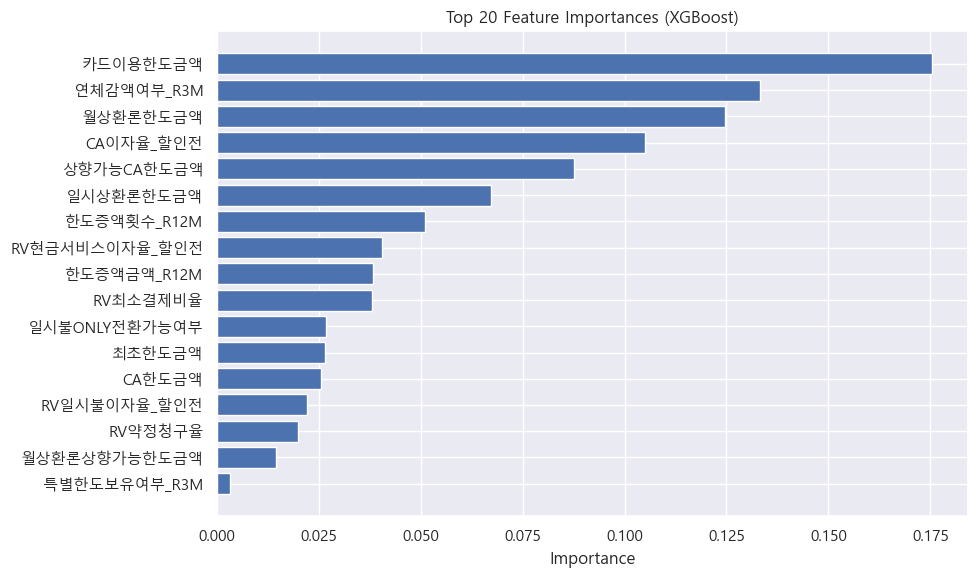

In [11]:
# 2. Feature importance 수치 추출 및 시각화 (gain 기준)
importances = best_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# 3. 상위 20개 bar 시각화
plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance_df['feature'][:20][::-1], 
    feature_importance_df['importance'][:20][::-1]
)
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()

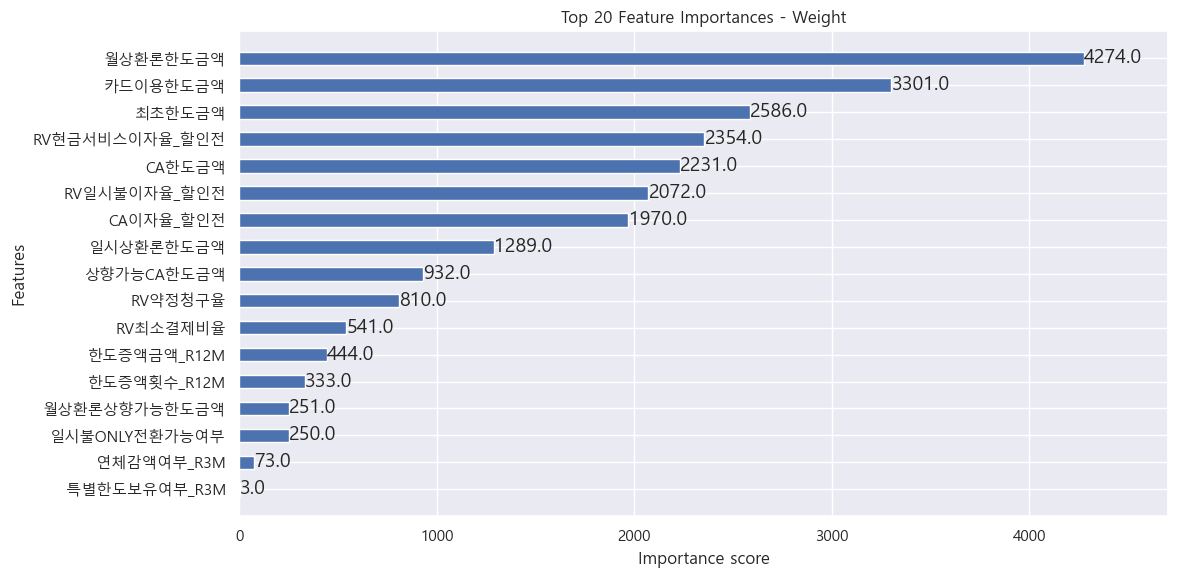

In [12]:
# 4. XGBoost 기본 제공 plot_importance (중복 import 제거)
plot_importance(
    booster, 
    max_num_features=20, 
    height=0.5, 
    importance_type='weight'  # 'gain', 'cover', 'weight' 중 선택 가능
)
plt.title('Top 20 Feature Importances - Weight')
plt.tight_layout()
plt.show()

### SHAP, B 피처에 확률 파악
- TreeExplainer: 클래스 B에 더 집중
- shap.explanier: 전체 클래스 기반

 98%|===================| 2456/2500 [00:30<00:00]        

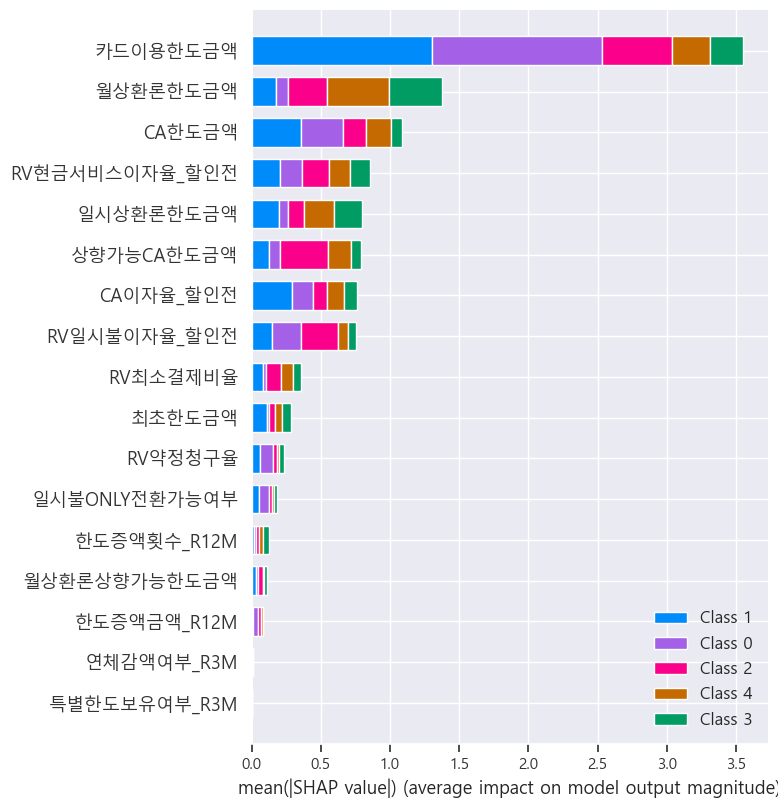

In [20]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# ✅ DataFrame으로 변환된 X에서 인덱스를 기준으로 추출
# 예: train_X는 numpy array지만, X는 원본 DataFrame이라고 가정
X_df = pd.DataFrame(train_X, columns=feature_names)

# 샘플 일부만 추출
X_sample = X_df.sample(n=500, random_state=42)

# SHAP Explainer 생성
explainer = shap.Explainer(best_model, X_df)

# SHAP 값 계산
shap_values = explainer(X_sample)

# summary plot
shap.summary_plot(shap_values, X_sample, plot_type="bar")

In [22]:
# 학습 모델 등을 저장한다.
with open(best_model_path, 'wb') as fp :
    pickle.dump(best_model, fp)
    pickle.dump(encoder1, fp)
    pickle.dump(scaler1, fp)

print('저장완료')

저장완료


In [24]:
# 저장 확인
with open(best_model_path, 'rb') as fp :
    test_model = pickle.load(fp)
    test_encoder = pickle.load(fp)
    test_scaler1 = pickle.load(fp)

📌 F1 Score (micro): 0.8326

📊 Classification Report:
              precision    recall  f1-score   support

           A       0.91      0.44      0.59       972
           B       1.00      0.50      0.67       144
           C       0.60      0.29      0.39    127590
           D       0.56      0.27      0.37    349242
           E       0.86      0.97      0.91   1922052

    accuracy                           0.83   2400000
   macro avg       0.79      0.49      0.58   2400000
weighted avg       0.80      0.83      0.80   2400000

📊 Confusion Matrix:
[[    425       0     319      62     166]
 [      0      72      57       4      11]
 [     31       0   36365   28409   62785]
 [      6       0   14064   95124  240048]
 [      4       0    9596   46160 1866292]]


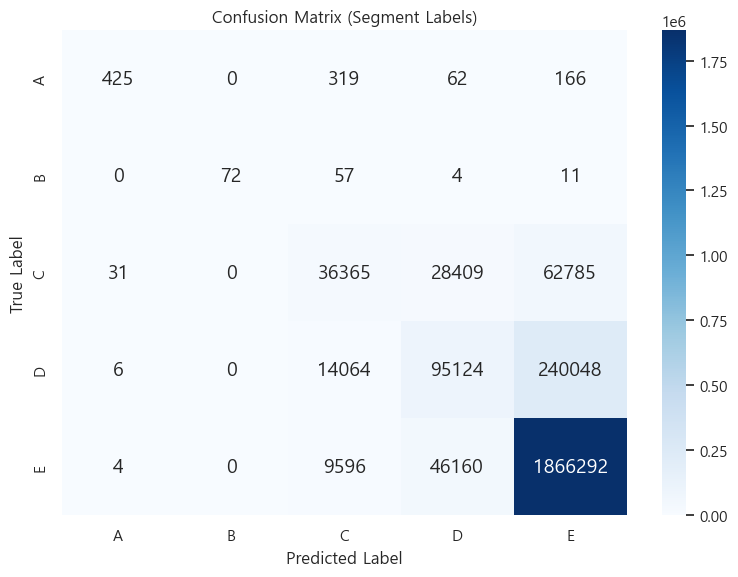

In [26]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 예측
y_pred = test_model.predict(train_X)

# 📌 F1 점수 계산 (macro)
f1 = f1_score(train_y, y_pred, average='micro')
print(f"📌 F1 Score (micro): {f1:.4f}")

# ✅ 원래 세그먼트 라벨로 복원
true_labels = encoder1.inverse_transform(train_y)
pred_labels = encoder1.inverse_transform(y_pred)
label_names = encoder1.classes_  # ['A', 'B', 'C', 'D', 'E']

# 📊 Classification Report (라벨명 기준)
print("\n📊 Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=label_names))

# 📊 Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels, labels=label_names)
print("📊 Confusion Matrix:")
print(cm)

# 🎨 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix (Segment Labels)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# 📊 1차 모델링 결과 요약

## ✅ 전체 성능 지표

- **F1 Score (micro)**: `0.8326`
- **Accuracy**: `0.83`
- **Macro avg F1-score**: `0.58`
- **Weighted avg F1-score**: `0.80`

> 📌 `macro avg`가 낮은 이유는 **클래스 불균형**으로, 특히 A~D 클래스의 성능이 낮기 때문

---

## 📋 클래스별 성능 상세

| Class | Precision | Recall | F1-score | Support | 해석 |
|-------|-----------|--------|----------|---------|------|
| A     | 0.91      | 0.44   | 0.59     | 972     | 높은 정밀도, 낮은 재현율 → 과소 예측 |
| B     | 1.00      | 0.50   | 0.67     | 144     | 정밀도 1.0, 재현율 낮음 (절반만 맞춤) |
| C     | 0.60      | 0.29   | 0.39     | 127,590 | 예측 성능 낮음, 혼동 심함 |
| D     | 0.56      | 0.27   | 0.37     | 349,242 | 예측 실패 경향, recall 낮음 |
| E     | 0.86      | 0.97   | 0.91     | 1,922,052 | 다수 클래스, 예측 거의 정확 |

> ✅ `E` 클래스는 너무 많아져서 다른 클래스가 **희생**되는 경향  
> ⚠️ `B`, `C`, `D`는 **과소 예측**, 특히 `C`와 `D`는 recall이 0.2~0.3대

---

## 🧠 Feature Importance 분석

### 🔹 XGBoost (Gain 기준 Top 5)
1. 카드이용한도금액
2. 연체감액여부_R3M
3. 월상환론한도금액
4. CA이자율_할인전
5. 상향가능CA한도금액

> → 대출 관련 정보와 이자율, 연체 여부가 주요 판단 기준

### 🔹 XGBoost (Weight 기준 Top 5)
1. 월상환론한도금액
2. 카드이용한도금액
3. 최초한도금액
4. RV현금서비스이자율_할인전
5. CA한도금액

### 🔹 SHAP Summary Plot
- 전체적으로 `카드이용한도금액`과 `월상환론한도금액`이 **모든 클래스에서 영향력 가장 큼**
- 클래스 별 SHAP 분포도에서도 **중복적으로 강한 영향력 확인**

---

## 🔍 Confusion Matrix 해석

- Class A/B/C/D → E로 잘못 분류된 케이스 많음
- 특히 D → E, C → E 오분류 큼
- B 클래스는 지원 수 자체가 적어 모델이 일반화 못함

---

## 🔧 개선 방향 제안

1. **클래스 불균형 보정**
   - SMOTE 등 OverSampling
   - UnderSampling (E 클래스 비중 낮추기)
   - `class_weight='balanced'` 또는 `scale_pos_weight` 설정

2. **소수 클래스 성능 개선**
   - One-vs-Rest 모델링
   - Cost-sensitive 학습 전략

3. **추가 피처 엔지니어링**
   - 이자율 구간 파생변수
   - 한도 대비 사용률(이용한도금액 / 한도금액) 비율 피처

4. **모델 앙상블 검토**
   - XGBoost 단일 모델 외에 LightGBM, VotingClassifier 조합 가능

---

> ✨ 필요하다면 시각화, 클래스별 SHAP 해석, 세부 개선 전략도 도와드릴게요!
